In [2]:
import tensorflow as tf

In [3]:
!unzip drive/MyDrive/'DIVP assignment'/'Copy of Database 1.zip'

Archive:  drive/MyDrive/DIVP assignment/Copy of Database 1.zip
 extracting: Database 1/apple-1.gif  
 extracting: Database 1/apple-10.gif  
 extracting: Database 1/apple-11.gif  
 extracting: Database 1/apple-12.gif  
 extracting: Database 1/apple-13.gif  
 extracting: Database 1/apple-14.gif  
 extracting: Database 1/apple-15.gif  
 extracting: Database 1/apple-16.gif  
 extracting: Database 1/apple-17.gif  
 extracting: Database 1/apple-18.gif  
 extracting: Database 1/apple-19.gif  
 extracting: Database 1/apple-2.gif  
 extracting: Database 1/apple-20.gif  
 extracting: Database 1/apple-3.gif  
 extracting: Database 1/apple-4.gif  
 extracting: Database 1/apple-5.gif  
 extracting: Database 1/apple-6.gif  
 extracting: Database 1/apple-7.gif  
 extracting: Database 1/apple-8.gif  
 extracting: Database 1/apple-9.gif  
 extracting: Database 1/bell-1.gif   
  inflating: Database 1/bell-10.gif  
 extracting: Database 1/bell-11.gif  
 extracting: Database 1/bell-12.gif  
 extracting: D

Now we will preprocess the images. In order to do that, we have to Create a new directory with a similar file structure.

The following preprocessing steps will take place:
0. Convert to binary
1. Noise removal using morphological operation with kernel size of 3
2. Hole filling by identifying contours and filling them
3. Gaussian boundary smoothing with kernel size of 5
4. Set all images to the same size when training the model

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def preprocess_image(image):

  # Convert to 1 color channel
  gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

  # Invert the image
  inverted_image = cv2.bitwise_not(opening)

  # Convert to 1 color channel (again)
  inverted_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # Find contours
  contours, hierarchy = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
      cv2.drawContours(opening, contours, i, (255,255,255), thickness=cv2.FILLED)

  return opening

Since OpenCV does not support .gif files. We have to convert the images to .png, then convert them to binary images again

In [5]:
from PIL import Image
import os

directory = 'Database 1'

for filename in os.listdir(directory):
    if filename.endswith('.gif'):
        file_path = os.path.join(directory, filename)

        with Image.open(file_path) as img:
            new_filename = os.path.splitext(filename)[0] + '.png'
            new_file_path = os.path.join(directory, new_filename)
            img.save(new_file_path, 'PNG')



We will restructure the dataset by creating a new directory and sub-directories for every class

In [6]:
import shutil

DATABASE_DIR = 'Database 1'
NEW_DIR = "dataset"

image_files = [f for f in os.listdir(DATABASE_DIR) if f.endswith('.png')]

for filename in image_files:
  class_name = filename.split('-')[0]
  target_dir = os.path.join(NEW_DIR, class_name)

  if not os.path.exists(target_dir):
    os.makedirs(target_dir)

  image_path = os.path.join(DATABASE_DIR, filename)
  image = cv2.imread(image_path)
  preprocessed_image = preprocess_image(image)

  dst_file = os.path.join(target_dir, os.path.splitext(filename)[0] + '.png')
  cv2.imwrite(dst_file, preprocessed_image)


Now we will generate the dataset objects so we can train a Neural Network.

In [129]:
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory=NEW_DIR,
                                                            color_mode='grayscale',
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            seed=42)

Found 400 files belonging to 20 classes.


We will create a Neural Network model with the following layers:
* Fully-Connected layer with 1 neuron (Input)
* Fully-Connected layer with 2 neurons
* Flattening layer (Convert tensor into feature vector)
* Fully-Connected layer with 20 neurons (Output) with softmax activation

The model will be compiled with:
* Adam optimizer with `learning_rate` = 0.001 (Default)
* Loss function will be `CategoricalCrossentropy` which is best for multi-class
* The model's accuracy will be the metric of choice



In [25]:
model_0 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=IMG_SIZE + (1,)),
  # tf.keras.layers.MaxPool2D(pool_size=2),
  # tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=10),
  tf.keras.layers.Flatten(name="flatten"),
  tf.keras.layers.Dense(20, activation="softmax")
])

model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])


In [26]:
history_0 = model_0.fit(train_dataset, epochs=5)

Epoch 1/5
13/13 [==============================] - 1s 22ms/step - loss: 36.6070 - accuracy: 0.2950
Epoch 2/5
13/13 [==============================] - 1s 24ms/step - loss: 4.7354 - accuracy: 0.7900
Epoch 3/5
13/13 [==============================] - 1s 25ms/step - loss: 1.3684 - accuracy: 0.9300
Epoch 4/5
13/13 [==============================] - 1s 25ms/step - loss: 0.3156 - accuracy: 0.9800
Epoch 5/5
13/13 [==============================] - 1s 24ms/step - loss: 0.0347 - accuracy: 0.9950


Let's test to see if the model can do predictions.

In [175]:
test_image = tf.io.read_file(os.path.join(NEW_DIR, 'apple') + '/apple-1.png')
test_image = tf.image.decode_image(test_image, channels=1)
test_image = tf.image.resize(test_image, size=IMG_SIZE)
test_image = tf.expand_dims(test_image, axis=0)

test_feature = model_0.predict(test_image)[0]
test_feature

1/1 [==============================] - 0s 53ms/step


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

Model correctly predicts the class of the image.

Let's get a summary of our model.

In [28]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 10)      100       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 10)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6250)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                125020    
                                                                 
Total params: 125120 (488.75 KB)
Trainable params: 125120 (488.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we will extract the feature vector of the `test_image` image.

In [163]:
final_output = model_0.predict(test_image)[0]
print(final_output)

1/1 [==============================] - 0s 19ms/step
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
features_layer = tf.keras.models.Model(
    inputs = model_0.inputs,
    outputs=model_0.get_layer(name="flatten").output,
)
test_feature = features_layer(test_image)
test_feature

<tf.Tensor: shape=(1, 6250), dtype=float32, numpy=
array([[0.00217174, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [165]:
apple_image = tf.io.read_file(os.path.join(DATABASE_DIR) + '/stef-01.png')
apple_image = tf.image.decode_image(apple_image, channels=1)
apple_image = tf.image.resize(apple_image, size=IMG_SIZE)
apple_image = tf.expand_dims(apple_image, axis=0)
apple_feature = model_0.predict(apple_image)

1/1 [==============================] - 0s 19ms/step


In [166]:
apple_feature

array([[2.4247908e-24, 5.9571852e-25, 1.8061049e-35, 5.0497462e-32,
        2.0264279e-14, 3.6811809e-31, 1.1870544e-29, 3.0506059e-32,
        2.7934956e-31, 9.6440701e-28, 1.3456602e-26, 1.2594085e-34,
        5.4327056e-28, 1.8628200e-26, 5.9302125e-22, 5.1754680e-35,
        1.0811533e-25, 6.8412853e-26, 1.0000000e+00, 1.0133603e-29]],
      dtype=float32)

In [106]:
test_feature_squeezed.shape

TensorShape([6250])

# Similarity ranking functions

In [20]:
from scipy.spatial.distance import euclidean
def compute_distance(vector1, vector2):
  return np.linalg.norm(vector1 - vector2)

In [21]:
def rank_images_by_similarity(query_features, dataset_features):
    distances = [compute_distance(query_features, features) for features in dataset_features]
    ranked_indices = np.argsort(distances)
    return ranked_indices

Now let's get feature vectors from each image in the database. (Should take around ~30 seconds to run the cell below)

In [124]:
dataset_directory = 'Database 1'

image_files = [(os.path.join(dataset_directory, f)) for f in os.listdir(dataset_directory) if f.endswith('.png')]


feature_vectors = []

for image_file in image_files:
  image_file = tf.io.read_file(image_file)
  image_file = tf.image.decode_image(image_file, channels=1)
  image_file = tf.image.resize(image_file, size=IMG_SIZE)
  image_file = tf.expand_dims(image_file, axis=0)
  feature_vectors.append(model_0.predict(image_file)[0])

1/1 [==============================] - 0s 21ms/step


In [65]:
feature_vectors = np.array(feature_vectors)
feature_vectors.shape

(400, 20)

In [142]:
ranked_indices = rank_images_by_similarity(apple_feature, feature_vectors)

N = 30
top_n_indices = ranked_indices[:N]

top_n_images = [image_files[i] for i in top_n_indices]

In [143]:
def display_images(top_n_image_paths):
  for i, file in enumerate(top_n_images):
    image = plt.imread(file)
    plt.subplot(6, 5, i + 1)
    plt.imshow(image, cmap='gray')

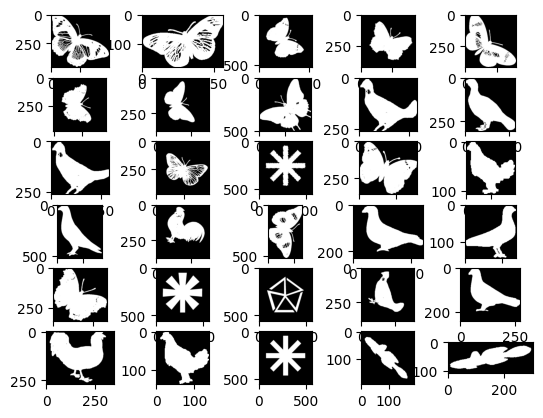

In [144]:
display_images(top_n_images)

In [160]:
model_0.save('drive/MyDrive/DIVP Assignment/DIVP_model_h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [130]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=IMG_SIZE + (1,)),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Flatten(name="flatten"),
  tf.keras.layers.Dense(20, activation="sigmoid")
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])


In [131]:
model_1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 254, 254, 10)      100       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 127, 127, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 10)      910       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 62, 62, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 60, 60, 10)        910       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 30, 30, 10)      

In [133]:
history_1 = model_1.fit(train_dataset, epochs=5)

Epoch 1/5
13/13 [==============================] - 14s 1s/step - loss: 1.0093 - accuracy: 0.7300
Epoch 2/5
13/13 [==============================] - 13s 1s/step - loss: 0.4595 - accuracy: 0.8775
Epoch 3/5
13/13 [==============================] - 13s 987ms/step - loss: 0.2013 - accuracy: 0.9550
Epoch 4/5
13/13 [==============================] - 13s 1s/step - loss: 0.0853 - accuracy: 0.9900
Epoch 5/5
13/13 [==============================] - 13s 1s/step - loss: 0.0331 - accuracy: 1.0000


In [140]:
apple_image = tf.io.read_file(os.path.join(DATABASE_DIR) + '/butterfly-1.png')
apple_image = tf.image.decode_image(apple_image, channels=1)
apple_image = tf.image.resize(apple_image, size=IMG_SIZE)
apple_image = tf.expand_dims(apple_image, axis=0)

Extract feature from inner layer

In [109]:
feature_extractor = tf.keras.Model(inputs=model_1.inputs, outputs=model_1.get_layer("flatten").output)
apple_feature = feature_extractor(apple_image)

Extract feature from output layer

In [141]:
apple_feature = model_1.predict(apple_image)[0]

1/1 [==============================] - 0s 32ms/step


In [110]:
apple_feature

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[1.14993248e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.76903808e-01, 7.60037731e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.22335901e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.12373447e+00, 0.00000000e+00, 1.67726159e+00, 0.00000000e+00,
        2.93718785e-01, 1.03712946e-01, 0.00000000e+00, 6.05588108e-02,
        0.00000000e+00, 4.13571358e-01, 3.39587688e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.14819584e+01, 0.00000000e+00, 0.00000000e+00, 2.76903808e-01,
        4.51834154e+00, 0.00000000e+00, 2.81066132e+00, 0.00000000e+00]],
      dtype=float32)>

In [14]:
model_1.save('model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [136]:
dataset_directory = 'Database 1'

image_files = [(os.path.join(dataset_directory, f)) for f in os.listdir(dataset_directory) if f.endswith('.png')]


feature_vectors = []

for image_file in image_files:
  image_file = tf.io.read_file(image_file)
  image_file = tf.image.decode_image(image_file, channels=1)
  image_file = tf.image.resize(image_file, size=IMG_SIZE)
  image_file = tf.expand_dims(image_file, axis=0)
  feature_vectors.append(model_1.predict(image_file)[0])

1/1 [==============================] - 0s 31ms/step


In [116]:
feature_vectors

[array([ 0.        ,  0.        ,  2.084604  ,  0.31108382,  0.        ,
         1.859364  ,  0.64766073,  0.        ,  0.18414105,  0.        ,
         6.966875  , 19.077457  ,  0.        , 31.393887  ,  0.        ,
        31.482386  , 27.236141  ,  0.        , 20.905966  , 15.147113  ,
         0.        ,  0.        ,  1.3041438 ,  0.4205717 ,  0.        ,
         0.2757618 ,  1.584053  ,  0.        ,  0.        ,  0.        ,
         3.0495825 ,  0.        ,  6.206756  ,  0.        ,  0.        ,
         5.2120004 , 12.058906  ,  0.        ,  6.9939094 ,  9.968162  ],
       dtype=float32),
 array([12.859277  ,  9.161608  ,  0.37677833,  5.6015377 ,  0.        ,
         0.        ,  0.18756096,  0.        ,  0.        ,  0.2667391 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.82769006,  0.        ,  0.        ,  0.        ,
        12.352616  ,  4.6001062 , 11.440548  , 10.71529   ,  0.        ,
        16.112164  ,  0.   

# Evaluation

In [203]:
def get_relevant_indices(image_files, query_idx):
  relevant_indices = []
  image_files = [image_file.split('-')[0] for image_file in image_files]
  for i, image_file in enumerate(image_files):
    if image_file == (image_files[query_idx]):
      relevant_indices.append(i)
  return relevant_indices

In [201]:
class_names = ['apple', 'bell', 'bird', 'butterfly', 'cattle',
               'chicken', 'chopper', 'cup', 'device2', 'device6',
               'dog', 'flatfish', 'frog', 'hat', 'horseshoe',
               'lmfish', 'personal_car', 'sea_snake', 'stef', 'turtle']

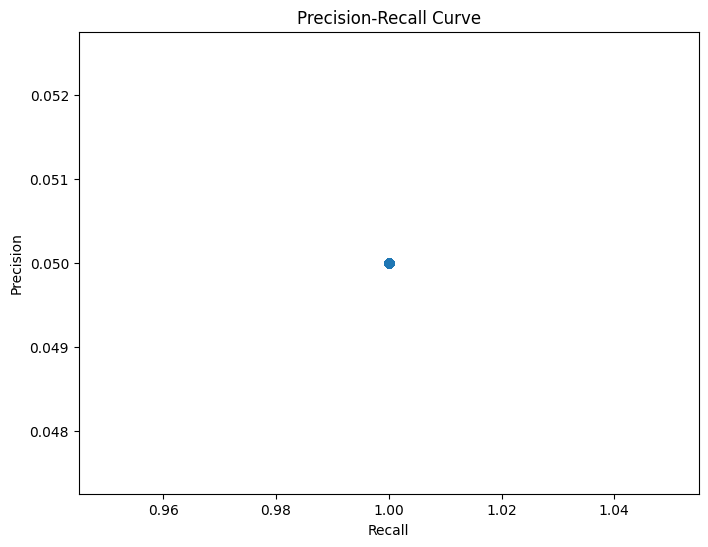

In [218]:
import numpy as np
import matplotlib.pyplot as plt

def is_relevant(index, relevant_indices):
    return index in relevant_indices


def calculate_precision_recall(retrieved_indices, relevant_indices):
    true_positives = sum(is_relevant(idx, relevant_indices) for idx in retrieved_indices)
    precision = true_positives / len(retrieved_indices)
    recall = true_positives / len(relevant_indices)
    return precision, recall

precisions = []
recalls = []

for query_idx, query_vector in enumerate(feature_vectors):
    retrieved_indices = rank_images_by_similarity(query_vector, feature_vectors)
    relevant_indices = get_relevant_indices(image_files, query_idx)

    N = 400
    precision, recall = calculate_precision_recall(retrieved_indices[:N], relevant_indices)
    precisions.append(precision)
    recalls.append(recall)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [215]:
precisions_recalls = np.array([precisions, recalls])
np.save('precisions_recalls', precisions_recalls)

In [171]:
get_relevant_indices(image_files, 2)

[2,
 15,
 23,
 72,
 80,
 90,
 91,
 106,
 117,
 126,
 137,
 147,
 160,
 247,
 251,
 268,
 287,
 319,
 350,
 387]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def is_relevant(index, relevant_indices):
    return index in relevant_indices

# Calculate precision and recall
def calculate_precision_recall(retrieved_indices, relevant_indices):
    true_positives = sum(is_relevant(idx, relevant_indices) for idx in retrieved_indices)
    precision = true_positives / len(retrieved_indices)
    recall = true_positives / len(relevant_indices)
    return precision, recall

all_precisions = []
all_recalls = []

class_precisions = {class_name: [] for class_name in class_names}  # Assuming class indices are 0-19
class_recalls = {class_name: [] for class_name in class_names}

for query_idx, query_vector in enumerate(feature_vectors):
    retrieved_indices = rank_images_by_similarity(query_vector, feature_vectors)
    relevant_indices, query_class = get_relevant_indices(image_files, query_idx)  # Modify to also return the class of the query

    # Calculate precision and recall for different cutoffs (top-k results)
    precisions = []
    recalls = []
    for k in range(1, len(retrieved_indices) + 1):
        precision, recall = calculate_precision_recall(retrieved_indices[:k], relevant_indices)
        precisions.append(precision)
        recalls.append(recall)

    # Store precision and recall in the dictionary under the correct class
    class_precisions[query_class].append(precisions)
    class_recalls[query_class].append(recalls)

# Create a 4x5 grid of subplots
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # Adjust the size as necessary
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

for i in range(20):
    for query_precisions, query_recalls in zip(class_precisions[i], class_recalls[i]):
        axes[i].plot(query_recalls, query_precisions)
    axes[i].set_title(f'Class {i+1}')  # Title for each subplot
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()